In [10]:
!pip install tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\sanat\AppData\Local\Temp\pip-install-hvhj3zld\tensorflow-gpu_66b029dccdae4e63b0f1294f5a72876e\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [12]:
import os
import gc
import random
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, concatenate)
from tensorflow.keras.models import Sequential
from itertools import product
from sklearn.model_selection import KFold



In [13]:
# ✅ Force GPU Usage & Prevent TPU/CPU Execution
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use first GPU
tf.config.set_visible_devices(tf.config.list_physical_devices("GPU"), "GPU")

In [14]:
# ✅ Enable GPU memory growth to prevent crashes
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [15]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs detected")


No GPUs detected


In [16]:
# Configuration
rows, cols = 200, 200
n_neurons = 100
n_feature = 9
batch_size = 70
num_classes = 10

class fuzzy_inference_block(tf.keras.layers.Layer):
    def __init__(self, output_dim, i_fmap, mu, sigma):
        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma
        super(fuzzy_inference_block, self).__init__()

    def build(self, input_shape):
        self.mu_map = tf.transpose(tf.convert_to_tensor(out_fRules, dtype=tf.float32)) * self.mu
        self.sigma_map = tf.ones((n_feature, self.output_dim)) * self.sigma
        super().build(input_shape)

    def call(self, inputs):
        fMap = inputs[:, n_feature * self.index : n_feature * (self.index + 1)]
        aligned_x = tf.repeat(tf.expand_dims(fMap, axis=-1), self.output_dim, axis=-1)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map
        phi = tf.exp(-tf.reduce_sum(tf.square(aligned_x - aligned_c) / (2 * tf.square(aligned_s)), axis=-2))
        return phi


In [17]:
def load_and_preprocess_data(image_dir):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(rows, cols),
        batch_size=batch_size
    )

    images, labels = [], []

    for image_batch, label_batch in train_ds:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())

    train_images = np.vstack(images) / 255.0  # Normalize images
    train_labels = np.concatenate(labels)

    return train_images, train_labels, train_ds.class_names


In [18]:
def fcnn(n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=True):
    with tf.device('/GPU:0'):  # ✅ Force all computations to GPU
        inp = Input(shape=[rows, cols, 3])

        conv1 = Conv2D(32, (3, 3), padding='valid', activation='relu')(inp)
        conv1 = MaxPooling2D((2, 2))(conv1)

        conv2 = Conv2D(64, (3, 3), padding='valid', activation='relu')(conv1)
        conv2 = MaxPooling2D((2, 2))(conv2)

        conv3 = Conv2D(64, (3, 3), padding='valid', activation='relu')(conv2)
        conv3 = MaxPooling2D((2, 2))(conv3)

        conv4 = Conv2D(n_femap, (4, 4), padding='same', strides=(stride,stride), activation='relu')(conv3)
        if dropout:
            conv4 = Dropout(0.2)(conv4)

        fMaps = Flatten()(conv4)

        fuzzy_inference = [fuzzy_inference_block(n_neurons, i, mu, sigma)(fMaps) for i in range(n_femap)]
        merged = concatenate(fuzzy_inference, axis=1)

        out = Dense(num_classes, activation='softmax')(merged)

        model = tf.keras.Model(inp, out)
        return model

In [19]:
import tensorflow as tf
import gc

def train_model(model_func, train_images, train_labels, no_epochs=300, optimizer='adam',
                n_femap=80, stride=2, mu=3.0, sigma=1.2, dropout=True, show=True, batch_size=32):
    print("Train images shape:", train_images.shape)
    print("Train labels shape:", train_labels.shape)

    tf.keras.backend.clear_session()
    with tf.device('/GPU:0'):  # ✅ Ensure training happens on GPU
        model = model_func(n_femap=n_femap, stride=stride, mu=mu, sigma=sigma, dropout=dropout)
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        history = model.fit(
            train_images,
            train_labels,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=show
        )

        scores = model.evaluate(train_images, train_labels, verbose=0)
        model.save('new_fuzzy.h5')
        print(f'Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%')

        gc.collect()

    return history, [scores[0], scores[1] * 100]

In [20]:
# Initialize fuzzy rules
fRules = list(product([-1.0, 0.0, 1.0], repeat=n_feature))
out_fRules = random.sample(fRules, n_neurons)

In [21]:
 # ✅ Load and preprocess data
train_images, train_labels, class_names = load_and_preprocess_data(
    'train_images'
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [22]:
# ✅ Train the model on GPU
fcnn_foldperf, fcnn_scores = train_model(
    fcnn,
    train_images,
    train_labels,
    no_epochs=300,
    optimizer='adam',
    show=True
)


Train images shape: (8326, 200, 200, 3)
Train labels shape: (8326,)
Epoch 1/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 61s 187ms/step - loss: 2.2356 - sparse_categorical_accuracy: 0.1677
Epoch 2/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 59s 227ms/step - loss: 2.1647 - sparse_categorical_accuracy: 0.1711
Epoch 3/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 75s 286ms/step - loss: 2.1764 - sparse_categorical_accuracy: 0.1801
Epoch 4/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 70s 267ms/step - loss: 2.1542 - sparse_categorical_accuracy: 0.1886
Epoch 5/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - loss: 2.1353 - sparse_categorical_accuracy: 0.2004
Epoch 6/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 193ms/step - loss: 2.1131 - sparse_categorical_accuracy: 0.2298
Epoch 7/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 201ms/step - loss: 2.0985 - sparse_categorical_accuracy: 0.2278
Epoch 8/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 208ms/step - loss: 2.0747 - sparse_categorical_accuracy: 0.2407
Epoch 9/300
261/261 ━━━━━━━━━━━━━━━━━━━━ 58s 221ms/step - lo

Loss: 0.0886, Accuracy: 97.89%


In [23]:
import matplotlib.pyplot as plt

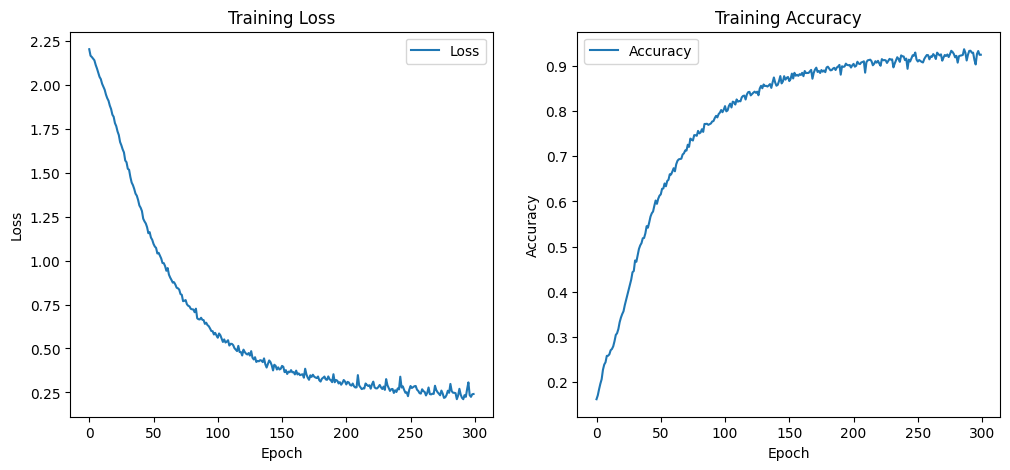

In [26]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(fcnn_foldperf.history['loss'], label='Loss')  
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(fcnn_foldperf.history['sparse_categorical_accuracy'], label='Accuracy')  
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Num GPUs Available: 0
Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


AttributeError: '_MapDataset' object has no attribute 'class_names'